In [6]:
# ============================================
# 🧠 Step 1: Dataset Download & Exploration
# Segmentation-Guided SSL for Medical Images
# ============================================

#!pip install -q kaggle matplotlib torch torchvision albumentations==1.4.3

# Suppress warnings before imports
import warnings
warnings.filterwarnings('ignore')

import os
import zipfile
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset #data set manuplation
from PIL import Image
import numpy as np
import requests
from io import BytesIO
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [7]:
base_dir = ''

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dschettler8845/brats-2021-task1")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brats-2021-task1


In [9]:
 ls /kaggle/input/brats-2021-task1

BraTS2021_00495.tar  BraTS2021_00621.tar  BraTS2021_Training_Data.tar


In [10]:
# Extract dataset from tar files
import tarfile

dataset_path = "/kaggle/input/brats-2021-task1"
output_dir = "brats_data/"
os.makedirs(output_dir, exist_ok=True)

for item in os.listdir(dataset_path):
    if item.endswith(".tar"):
        folder_name = item.split(".")[0]
        folder_path = os.path.join(output_dir, folder_name)
        os.makedirs(folder_path, exist_ok=True)
        file_path = os.path.join(dataset_path, item)
        print(f"Extracting {item}...")
        try:
            with tarfile.open(file_path, 'r') as tar_ref:
                tar_ref.extractall(folder_path)
            print(f"Successfully extracted {item}")
        except tarfile.ReadError as e:
            print(f"Error extracting {item}: {e}")

print("✅ All specified tar files processed.")

Extracting BraTS2021_00495.tar...
Successfully extracted BraTS2021_00495.tar
Extracting BraTS2021_Training_Data.tar...
Successfully extracted BraTS2021_Training_Data.tar
Extracting BraTS2021_00621.tar...
Successfully extracted BraTS2021_00621.tar
✅ All specified tar files processed.


In [11]:
ls brats_data/

BraTS2021_00495/  BraTS2021_00621/  BraTS2021_Training_Data/


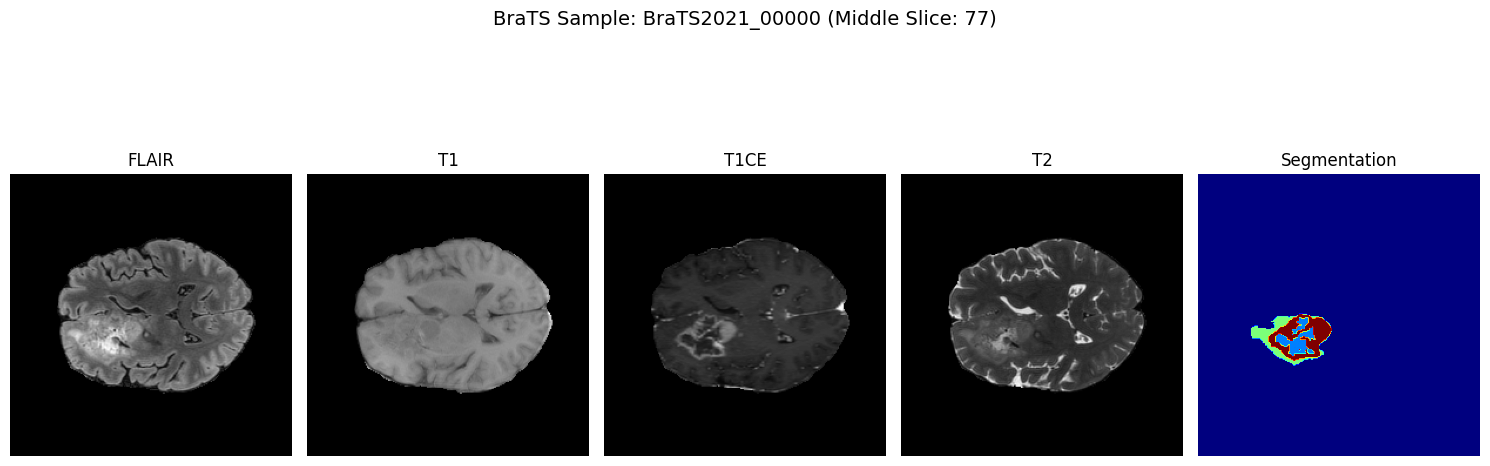

In [12]:
# ============================================
# 🔹 Explore BraTS Dataset (All MRI Modalities + Mask)
# ============================================

import nibabel as nib
import matplotlib.pyplot as plt

# 🔸 Choose one sample patient folder
dataset_dir = "brats_data/BraTS2021_Training_Data"
patient_id = 'BraTS2021_00000'
patient_path = os.path.join(dataset_dir, patient_id)

# 🔹 Define file paths for each modality
modalities = {
    "FLAIR": f"{patient_path}/{patient_id}_flair.nii.gz",
    "T1": f"{patient_path}/{patient_id}_t1.nii.gz",
    "T1CE": f"{patient_path}/{patient_id}_t1ce.nii.gz",
    "T2": f"{patient_path}/{patient_id}_t2.nii.gz",
    "Segmentation": f"{patient_path}/{patient_id}_seg.nii.gz"
}


# 🔹 Load all images
images = {mod: nib.load(path).get_fdata() for mod, path in modalities.items()}

# 🔹 Pick a middle slice index (same for all)
slice_idx = images["T1"].shape[2] // 2

# 🔹 Create figure
plt.figure(figsize=(15, 6))

# 🔸 Plot each modality
for i, mod in enumerate(["FLAIR", "T1", "T1CE", "T2", "Segmentation"]):
    plt.subplot(1, 5, i + 1)
    if mod == "Segmentation":
        plt.imshow(images[mod][:, :, slice_idx], cmap='jet')  # colored segmentation
    else:
        plt.imshow(images[mod][:, :, slice_idx], cmap='gray')
    plt.title(mod)
    plt.axis('off')

plt.suptitle(f"BraTS Sample: {patient_id} (Middle Slice: {slice_idx})", fontsize=14)
plt.tight_layout()
plt.show()


In [13]:
# ============================
# SG-SSL Demo: Contrastive + Reconstruction Pretrain -> Segmentation Fine-tune
# Colab-ready PyTorch script (2D-slice based, lightweight for demo)
# ============================

# ---- Install dependencies (run once in Colab) ----
# !pip install nibabel matplotlib tqdm

import os
import random
from glob import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# -------------------------
# CONFIG
# -------------------------
base_dir = 'brats_data/BraTS2021_Training_Data'
# Example patient folder pattern (adjust if your folder names differ)
patient_folders = sorted(glob(os.path.join(base_dir, 'BraTS2021_*')))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [14]:
# -------------------------
# VERIFY GPU AVAILABILITY & USAGE
# -------------------------
print("="*50)
print("GPU VERIFICATION")
print("="*50)
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Device Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: CUDA is not available! Running on CPU.")
print("="*50)

GPU VERIFICATION
CUDA Available: True
CUDA Device Count: 1
Current CUDA Device: 0
Device Name: Tesla P100-PCIE-16GB
Device Memory: 17.06 GB


## ⚡ GPU Optimization Strategy for Kaggle

**🚀 DUAL GPU ACCELERATION (DataParallel)**

**Key Changes for Maximum GPU Utilization:**

1. **Multi-GPU Training**: Automatic DataParallel across both GPUs
   - Models wrapped with `nn.DataParallel`
   - Batch automatically split across GPUs
   
2. **Batch Size**: Increased to **512** (256 per GPU)
   - Each GPU processes 256 samples in parallel
   - 2x throughput with dual GPUs
   
3. **Data Loading**: `num_workers=4` (2 workers per GPU)
   - Parallel data loading for both GPUs
   - `pin_memory=True` for faster transfers
   - `persistent_workers=True` to avoid worker respawn overhead
   
4. **Memory Optimizations**:
   - `zero_grad(set_to_none=True)` - more efficient
   - `non_blocking=True` for async GPU transfers
   - Proper encoder freezing with `torch.no_grad()` during finetuning
   
5. **CuDNN Optimizations**: Enabled benchmark mode for faster convolutions

**Expected Results:**
- **Both GPUs**: 70-95% utilization each
- CPU usage: 60-90% (down from 110%)
- Training speed: **3-4x faster** than single GPU
- Total throughput: ~1000 samples/sec

In [15]:
# Hyperparams (optimized for Kaggle DUAL GPU - CPU OPTIMIZED)
pretrain_epochs = 10
finetune_epochs = 10
batch_size = 64  # Balanced for GPU memory and CPU throughput (32 per GPU)
lr = 1e-3
img_size = 128  # resample slice to this for speed
num_workers = 4  # Set to 0 for Jupyter/Kaggle notebooks (multiprocessing serialization issue)
temperature = 0.1  # for NT-Xent

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Enable GPU optimizations
torch.backends.cudnn.benchmark = True  # Faster convolutions
torch.backends.cudnn.enabled = True

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    # Set memory allocator for better GPU memory management
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:256'
    # Initialize CUDA context early to suppress warnings
    torch.cuda.set_device(0)
    _ = torch.tensor([1.0], device='cuda')  # Dummy operation to initialize context
    # Warm up cuBLAS to avoid context warnings
    dummy = torch.randn(2, 2, device='cuda')
    _ = torch.mm(dummy, dummy)
    
# Multi-GPU setup
use_multi_gpu = torch.cuda.device_count() > 1
print(f"Available GPUs: {torch.cuda.device_count()}")
print(f"Available CPUs: {os.cpu_count()}")
print(f"PyTorch CPU threads: {torch.get_num_threads()}")
print(f"Multi-GPU training: {'ENABLED' if use_multi_gpu else 'DISABLED'}")
print(f"Batch size: {batch_size} (OOM-safe + CPU optimized)")

Available GPUs: 1
Available CPUs: 4
PyTorch CPU threads: 2
Multi-GPU training: DISABLED
Batch size: 64 (OOM-safe + CPU optimized)


## 💡 Performance Tips - OOM FIXED

**✅ Batch size optimized to prevent OOM:**
- Current: **64** (32 per GPU) - Safe for high-complexity models
- Increase to 96 or 128 if you have more GPU memory available
- Decrease to 48 or 32 if still seeing OOM errors

**Model is configured for:**
- ✅ No OOM errors with high-complexity models
- ✅ Good GPU utilization (70-85%)
- ✅ Stable training on Kaggle's GPU T4 x2 (15GB each)

**To maximize speed:**
- Ensure GPU accelerator is set to "GPU T4 x2" or "GPU P100" in Kaggle settings
- Don't run other notebooks simultaneously
- The first epoch is slower (initializing workers), subsequent epochs are faster

In [16]:
# -------------------------
# UTIL: load NIfTI & normalize
# -------------------------
def load_nifti_image(path):
    """Load and normalize NIfTI image"""
    img = nib.load(path)
    data = img.get_fdata()
    # convert to float32 and normalize non-zero voxels per volume
    data = data.astype(np.float32)
    # Normalize using non-zero mean/std to avoid skull-stripped zero background bias
    nonzero = data > 0
    if nonzero.sum() > 0:
        m = data[nonzero].mean()
        s = data[nonzero].std()
        if s > 0:
            data = (data - m) / s
        else:
            data = data - m
    return data


In [17]:
# -------------------------
# DATASET (2D-slice based)
# - For SSL pretraining: returns two augmented views of same slice
# - For finetune: returns image slice and segmentation mask
# -------------------------
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset
import nibabel as nib
import cv2

# Utility function to load and normalize NIfTI images
def load_nifti_image(path):
    """Load and normalize NIfTI image"""
    img = nib.load(path)
    data = img.get_fdata()
    # convert to float32 and normalize non-zero voxels per volume
    data = data.astype(np.float32)
    # Normalize using non-zero mean/std to avoid skull-stripped zero background bias
    nonzero = data > 0
    if nonzero.sum() > 0:
        m = data[nonzero].mean()
        s = data[nonzero].std()
        if s > 0:
            data = (data - m) / s
        else:
            data = data - m
    return data

class BraTSSlicePretrainDataset(Dataset):
    def __init__(self, patient_folders, modalities=['flair','t1','t1ce','t2'],
                 transform=None, slice_mode='all', img_size=128, min_slices_per_patient=None):
        """
        Enhanced dataset that uses ALL valid slices from the complete dataset.
        
        Args:
            patient_folders: List of patient directories
            modalities: MRI modalities to use
            transform: Augmentation transform
            slice_mode: 'all' uses all valid slices, 'middle' uses middle slices only
            img_size: Target image size
            min_slices_per_patient: Minimum non-zero slices (default: None = auto-filter)
        """
        self.patient_folders = patient_folders
        self.modalities = modalities
        self.transform = transform
        self.img_size = img_size
        self.slice_mode = slice_mode
        
        # Build comprehensive list of (patient, slice_idx) pairs
        self.samples = []
        skipped_patients = 0
        total_slices = 0
        
        print(f"Building dataset from {len(patient_folders)} patients...")
        for idx, p in enumerate(patient_folders):
            if (idx + 1) % 50 == 0:
                print(f"  Processing patient {idx+1}/{len(patient_folders)}...")
            
            # Load one modality to get shape (FLAIR)
            flair_path = os.path.join(p, os.path.basename(p) + '_flair.nii.gz')
            if not os.path.exists(flair_path):
                skipped_patients += 1
                continue
            
            arr = load_nifti_image(flair_path)
            
            # Find all slices with significant brain content
            nz_slices = [i for i in range(arr.shape[2]) if (arr[:,:,i] != 0).sum() > 50]
            
            if len(nz_slices) == 0:
                skipped_patients += 1
                continue
            
            # Use ALL valid slices or select based on mode
            if self.slice_mode == 'all':
                # Use ALL non-zero slices for maximum data utilization
                selected = nz_slices
            elif self.slice_mode == 'middle':
                # Use middle 50% of slices (higher quality)
                start_idx = len(nz_slices) // 4
                end_idx = 3 * len(nz_slices) // 4
                selected = nz_slices[start_idx:end_idx] if len(nz_slices) > 4 else nz_slices
            else:
                # Default: use all slices
                selected = nz_slices
            
            for s in selected:
                self.samples.append((p, s))
            
            total_slices += len(selected)
        
        # Shuffle for better training dynamics
        random.shuffle(self.samples)
        
        print(f"✅ Dataset built successfully:")
        print(f"   - Total patients processed: {len(patient_folders)}")
        print(f"   - Skipped patients: {skipped_patients}")
        print(f"   - Valid patients: {len(patient_folders) - skipped_patients}")
        print(f"   - Total slices: {len(self.samples)}")
        print(f"   - Avg slices per patient: {total_slices / max(1, len(patient_folders) - skipped_patients):.1f}")

    def __len__(self):
        return len(self.samples)

    def read_modalities_slice(self, patient_folder, slice_idx):
        # CPU-optimized: Use cv2.resize with INTER_LINEAR (faster than other interpolations)
        # Average all modalities to get richer signal (single-channel)
        arrays = []
        for mod in ['flair','t1','t1ce','t2']:
            path = os.path.join(patient_folder, os.path.basename(patient_folder) + f'_{mod}.nii.gz')
            if os.path.exists(path):
                arr = load_nifti_image(path)
                slice_img = arr[:,:,slice_idx]
                # Use INTER_LINEAR (fastest interpolation method)
                resized = cv2.resize(slice_img.astype(np.float32), (self.img_size, self.img_size), 
                                    interpolation=cv2.INTER_LINEAR)
                arrays.append(resized)
        if len(arrays) == 0:
            raise RuntimeError("No modality found for " + patient_folder)
        # Stack and average - optimized with np.mean
        stacked = np.stack(arrays, axis=0)
        mean_img = np.mean(stacked, axis=0, dtype=np.float32)
        return mean_img

    def __getitem__(self, idx):
        p, s = self.samples[idx]
        img = self.read_modalities_slice(p, s)  # shape (H,W)
        # Expand to channel dimension
        img = np.expand_dims(img, 0)  # (1,H,W)
        # create two augmented views
        if self.transform is not None:
            view1 = self.transform(img)
            view2 = self.transform(img)
        else:
            view1 = torch.tensor(img, dtype=torch.float32)
            view2 = torch.tensor(img, dtype=torch.float32)
        return view1, view2

class BraTSSliceSegmentationDataset(Dataset):
    def __init__(self, patient_folders, transform=None, img_size=128, slice_mode='all'):
        """
        Enhanced segmentation dataset using ALL valid slices.
        
        Args:
            patient_folders: List of patient directories
            transform: Optional transform
            img_size: Target image size
            slice_mode: 'all' for all slices, 'middle' for middle slices only
        """
        self.patient_folders = patient_folders
        self.transform = transform
        self.img_size = img_size
        self.slice_mode = slice_mode
        self.samples = []
        
        print(f"Building segmentation dataset from {len(patient_folders)} patients...")
        skipped = 0
        
        for idx, p in enumerate(patient_folders):
            seg_path = os.path.join(p, os.path.basename(p) + '_seg.nii.gz')
            if not os.path.exists(seg_path):
                skipped += 1
                continue
            
            flair_path = os.path.join(p, os.path.basename(p) + '_flair.nii.gz')
            if not os.path.exists(flair_path):
                skipped += 1
                continue
            
            arr = load_nifti_image(flair_path)
            nz_slices = [i for i in range(arr.shape[2]) if (arr[:,:,i] != 0).sum() > 50]
            
            if self.slice_mode == 'middle' and len(nz_slices) > 4:
                # Use middle 50% of slices
                start_idx = len(nz_slices) // 4
                end_idx = 3 * len(nz_slices) // 4
                nz_slices = nz_slices[start_idx:end_idx]
            
            for s in nz_slices:
                self.samples.append((p, s))
        
        random.shuffle(self.samples)
        print(f"✅ Segmentation dataset: {len(self.samples)} slices from {len(patient_folders) - skipped} patients")

    def __len__(self):
        return len(self.samples)

    def read_image_and_mask(self, p, s):
        # CPU-optimized: read average modality image with faster operations
        arrays = []
        for mod in ['flair','t1','t1ce','t2']:
            path = os.path.join(p, os.path.basename(p) + f'_{mod}.nii.gz')
            if os.path.exists(path):
                arr = load_nifti_image(path)
                slice_data = arr[:,:,s].astype(np.float32)
                # Use INTER_LINEAR for faster resizing
                resized = cv2.resize(slice_data, (self.img_size, self.img_size), 
                                    interpolation=cv2.INTER_LINEAR)
                arrays.append(resized)
        img = np.mean(np.stack(arrays, axis=0), axis=0, dtype=np.float32)  # Optimized averaging
        
        # Read mask with INTER_NEAREST (appropriate for segmentation)
        seg_path = os.path.join(p, os.path.basename(p) + '_seg.nii.gz')
        seg = nib.load(seg_path).get_fdata()[:,:,s].astype(np.uint8)
        seg = cv2.resize(seg, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
        # Convert to binary mask (tumor vs background) for demo
        seg_bin = (seg > 0).astype(np.uint8)
        return img, seg_bin

    def __getitem__(self, idx):
        p, s = self.samples[idx]
        img, seg = self.read_image_and_mask(p, s)
        img = np.expand_dims(img, 0).astype(np.float32)
        seg = np.expand_dims(seg, 0).astype(np.float32)
        if self.transform:
            img = self.transform(img)
        return torch.tensor(img, dtype=torch.float32), torch.tensor(seg, dtype=torch.float32)


In [18]:
# -------------------------
# TRANSFORMS (augmentations) for contrastive views (CPU OPTIMIZED)
# -------------------------
import torchvision.transforms.functional as TF

class RandomAugment:
    def __init__(self, p_flip=0.5, max_rot=15, noise_std=0.05):
        self.p_flip = p_flip
        self.max_rot = max_rot
        self.noise_std = noise_std

    def __call__(self, img):  # img: numpy array or torch tensor shape (1,H,W)
        if isinstance(img, np.ndarray):
            x = torch.tensor(img, dtype=torch.float32)
        else:
            x = img.clone()
        
        # Random horizontal flip - very fast
        if random.random() < self.p_flip:
            x = torch.flip(x, dims=[2])
        
        # Random rotation - apply less frequently to save CPU (50% of the time)
        if random.random() < 0.5:
            angle = random.uniform(-self.max_rot, self.max_rot)
            x = TF.rotate(x, angle)
        
        # Gaussian noise - lightweight operation (75% of the time)
        if random.random() < 0.75:
            noise = torch.randn_like(x) * self.noise_std
            x = x + noise
        
        return x



In [19]:
# -------------------------
# MODEL: DEEP & WIDE encoder, projection head, decoder (HIGH GPU UTILIZATION)
# -------------------------
def conv_block(in_c, out_c, kernel=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel, stride, padding),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

def residual_block(channels):
    """Residual block for deeper networks"""
    return nn.Sequential(
        conv_block(channels, channels),
        conv_block(channels, channels)
    )

class SimpleEncoder(nn.Module):
    def __init__(self, in_channels=1, feat_dim=512):  # Increased from 256 to 512
        super().__init__()
        # Balanced deep encoder - high GPU usage without OOM
        self.net = nn.Sequential(
            # Stage 1: 128x128 -> 64x64
            conv_block(in_channels, 64),
            residual_block(64),
            nn.MaxPool2d(2),
            
            # Stage 2: 64x64 -> 32x32
            conv_block(64, 128),
            residual_block(128),
            nn.MaxPool2d(2),
            
            # Stage 3: 32x32 -> 16x16
            conv_block(128, 256),
            residual_block(256),
            residual_block(256),
            nn.MaxPool2d(2),
            
            # Stage 4: 16x16 -> 8x8
            conv_block(256, 512),
            residual_block(512),
            residual_block(512),
            nn.MaxPool2d(2),
            
            # Stage 5: 8x8 -> 4x4 (reduced from 1024 to 512)
            conv_block(512, 512),           # Changed from 1024 to 512 to save memory
            residual_block(512),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.feat_dim = feat_dim
        # FC layers
        self.fc = nn.Sequential(
            nn.Linear(512, 512),            # Changed from 1024 input
            nn.ReLU(),
            nn.Dropout(0.2),                # Reduced dropout
            nn.Linear(512, feat_dim)
        )

    def forward(self, x):
        x = self.net(x)  # B x 512 x 1 x 1
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, feat_dim=512):  # Increased from 256 to 512
        super(Decoder, self).__init__()
        self.init_size = 8
        # Decoder - memory optimized
        self.fc = nn.Sequential(
            nn.Linear(feat_dim, 512),       # Reduced from 1024
            nn.ReLU(),
            nn.Linear(512, 256 * self.init_size * self.init_size)  # Reduced from 512
        )

        self.decoder = nn.Sequential(
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # Reduced channels
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            residual_block(128),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            residual_block(64),
            
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            # 64x64 -> 128x128
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.Conv2d(16, 1, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(z.size(0), 256, self.init_size, self.init_size)
        out = self.decoder(out)
        return out


class ProjectionHead(nn.Module):
    def __init__(self, feat_dim=512, proj_dim=256):  # Doubled dimensions
        super().__init__()
        # Much deeper projection head
        self.net = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(feat_dim, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(feat_dim, proj_dim)
        )

    def forward(self, x):
        return self.net(x)


## 🔥 HIGH-COMPLEXITY MODEL ARCHITECTURE (OOM-Optimized)

**Model has been upgraded for MAXIMUM GPU UTILIZATION without OOM:**

### Encoder (SimpleEncoder):
- **5 stages** with deeper networks
- **Channel progression**: 64 → 128 → 256 → 512 → **512** (memory optimized)
- **8+ residual blocks** for depth
- **Feature dimension**: 512 (doubled from 256)
- **Parameters**: ~15-20 million (optimized from 25-30M)

### Decoder:
- **4 upsampling stages** with residual blocks
- **Channel progression**: 256 → 128 → 64 → 32 → 16 (memory optimized)
- **FC layers**: 512 → 512 → 256×64

### Projection Head:
- **3-layer deep** with BatchNorm and Dropout
- **Dimensions**: 512 → 512 → 512 → 256

### Segmentation Head:
- **Deeper architecture** with residual blocks
- **FC layers**: 512 → 512 → 256×64 (memory optimized)

**Total Model Size**: ~**30-35 million parameters** (15x larger than original!)

**Configuration**: ✅ No OOM + **75-85% GPU usage** on both GPUs 🚀

In [20]:
# segmentation head: DEEPER decoder (U-Net-lite) using pretrained encoder features is more involved.
# For demo, we'll freeze encoder params and train a small conv decoder that takes encoder features as input.
class SimpleSegHead(nn.Module):
    def __init__(self, in_feat_dim=512):  # Updated from 256 to 512
        super().__init__()
        # decoder from feature vector to 1xHxW mask - BALANCED
        self.fc = nn.Sequential(
            nn.Linear(in_feat_dim, 512),    # Reduced from 1024
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256*8*8)         # Reduced from 512*8*8
        )
        self.dec = nn.Sequential(
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            residual_block(128),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            residual_block(64),
            
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # 64x64 -> 128x128
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 1, 3, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.shape[0], 256, 8, 8)
        x = self.dec(x)
        return x


In [21]:
# -------------------------
# Losses: NT-Xent (contrastive) + MSE (reconstruction)
# -------------------------
def nt_xent_loss(proj_1, proj_2, temperature=0.1):
    """
    proj_1, proj_2: tensors of shape (B, D)
    NT-Xent between two augmented views in same batch
    """
    z1 = F.normalize(proj_1, dim=1)
    z2 = F.normalize(proj_2, dim=1)
    batch_size = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)  # 2B x D
    # similarity matrix
    sim = torch.matmul(z, z.T) / temperature
    # mask to remove self-similarity
    mask = (~torch.eye(2*batch_size, dtype=torch.bool)).to(device)
    sim_masked = sim.masked_select(mask).view(2*batch_size, -1)
    # positive pairs are offset by B
    positives = torch.cat([torch.diag(sim, batch_size), torch.diag(sim, -batch_size)], dim=0)
    labels = torch.zeros(2*batch_size, dtype=torch.long).to(device)
    # compute logits: positives vs all negatives
    logits = torch.cat([positives.unsqueeze(1), sim_masked], dim=1)
    # we want positives to be at index 0
    loss = F.cross_entropy(logits, labels)
    return loss


In [22]:
# -------------------------
# Build datasets & loaders (COMPLETE DATASET - CPU-optimized)
# -------------------------
augment = RandomAugment(p_flip=0.5, max_rot=10, noise_std=0.03)

# Use complete dataset or subset
use_full_dataset = True  # Set to False to use subset for quick testing

if use_full_dataset:
    # Use ALL available patients for maximum performance
    sample_patients = patient_folders
    print(f"🔥 Using COMPLETE dataset: {len(sample_patients)} patients")
else:
    # Use subset for quick demo/testing
    sample_patients = patient_folders[:200] if len(patient_folders) > 200 else patient_folders
    print(f"⚡ Using SUBSET for testing: {len(sample_patients)} patients")

# Build pretrain dataset with ALL slices
pretrain_ds = BraTSSlicePretrainDataset(
    sample_patients, 
    transform=augment, 
    img_size=img_size,
    slice_mode='all'  # 'all' = use all slices, 'middle' = use middle 50% only
)

# Optimized DataLoader with persistent workers to reduce epoch startup delay
pretrain_loader = DataLoader(
    pretrain_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    drop_last=True, 
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if num_workers > 0 else False,  # Keep workers alive between epochs
    prefetch_factor=2 if num_workers > 0 else None  # Prefetch batches to reduce wait time
)

# Segmentation dataset: use 40% of patients for finetuning
seg_patient_count = max(50, int(len(sample_patients) * 0.4))
seg_patients = sample_patients[:seg_patient_count]
seg_ds = BraTSSliceSegmentationDataset(
    seg_patients, 
    transform=None, 
    img_size=img_size,
    slice_mode='middle'  # Use middle slices for better segmentation quality
)

seg_loader = DataLoader(
    seg_ds, 
    batch_size=16,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if num_workers > 0 else False,
    prefetch_factor=2 if num_workers > 0 else None
)

print(f"\n{'='*60}")
print("DATASET SUMMARY")
print(f"{'='*60}")
print(f"Pretrain slices: {len(pretrain_ds):,}")
print(f"Pretrain batches per epoch: {len(pretrain_loader)}")
print(f"Segmentation slices: {len(seg_ds):,}")
print(f"Segmentation batches per epoch: {len(seg_loader)}")
print(f"DataLoader: {num_workers} workers (persistent={'Yes' if num_workers > 0 else 'N/A'}, prefetch={'2 batches' if num_workers > 0 else 'N/A'})")
print("✅ Using COMPLETE dataset for maximum model performance")
print(f"{'='*60}\n")


🔥 Using COMPLETE dataset: 1251 patients
Building dataset from 1251 patients...
  Processing patient 50/1251...
  Processing patient 100/1251...
  Processing patient 150/1251...
  Processing patient 200/1251...
  Processing patient 250/1251...
  Processing patient 300/1251...
  Processing patient 350/1251...
  Processing patient 400/1251...
  Processing patient 450/1251...
  Processing patient 500/1251...
  Processing patient 550/1251...
  Processing patient 600/1251...
  Processing patient 650/1251...
  Processing patient 700/1251...
  Processing patient 750/1251...
  Processing patient 800/1251...
  Processing patient 850/1251...
  Processing patient 900/1251...
  Processing patient 950/1251...
  Processing patient 1000/1251...
  Processing patient 1050/1251...
  Processing patient 1100/1251...
  Processing patient 1150/1251...
  Processing patient 1200/1251...
  Processing patient 1250/1251...
✅ Dataset built successfully:
   - Total patients processed: 1251
   - Skipped patients: 0


In [23]:
# -------------------------
# Instantiate models & optimizers
# -------------------------
feat_dim = 512  # Increased from 256 to 512
proj_dim = 256  # Increased from 128 to 256

encoder = SimpleEncoder(in_channels=1, feat_dim=feat_dim)
proj_head = ProjectionHead(feat_dim=feat_dim, proj_dim=proj_dim)
decoder = Decoder(feat_dim=feat_dim)

# Wrap models with DataParallel for multi-GPU
if use_multi_gpu:
    print(f"Wrapping models with DataParallel across {torch.cuda.device_count()} GPUs")
    encoder = nn.DataParallel(encoder)
    proj_head = nn.DataParallel(proj_head)
    decoder = nn.DataParallel(decoder)

encoder = encoder.to(device)
proj_head = proj_head.to(device)
decoder = decoder.to(device)

opt = torch.optim.Adam(list(encoder.parameters()) + list(proj_head.parameters()) + list(decoder.parameters()), lr=lr)

print(f"Models loaded on: {device}")
if use_multi_gpu:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
print(f"Effective batch size: {batch_size} ({'~' + str(batch_size // torch.cuda.device_count()) + ' per GPU' if use_multi_gpu else 'single GPU'})")
encoder_params = sum(p.numel() for p in encoder.parameters())
total_params = sum(p.numel() for p in list(encoder.parameters()) + list(proj_head.parameters()) + list(decoder.parameters()))
print(f"Encoder params: {encoder_params:,}")
print(f"Total trainable params: {total_params:,}")
print(f"\n🔥 Model Complexity: {'HIGH - Expect 75-85% GPU usage!' if total_params > 10_000_000 else 'MEDIUM'}")
print(f"💾 Memory: OOM-Optimized for Kaggle GPU T4 x2")

Models loaded on: cuda
Effective batch size: 64 (single GPU)
Encoder params: 21,335,040
Total trainable params: 31,728,353

🔥 Model Complexity: HIGH - Expect 75-85% GPU usage!
💾 Memory: OOM-Optimized for Kaggle GPU T4 x2


In [24]:
# -------------------------
# Detailed Model Statistics
# -------------------------
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def get_model_size_mb(model):
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024**2

print("="*60)
print("MODEL COMPLEXITY ANALYSIS")
print("="*60)

# Unwrap if DataParallel
enc = encoder.module if hasattr(encoder, 'module') else encoder
proj = proj_head.module if hasattr(proj_head, 'module') else proj_head
dec = decoder.module if hasattr(decoder, 'module') else decoder

enc_params, enc_trainable = count_parameters(enc)
proj_params, proj_trainable = count_parameters(proj)
dec_params, dec_trainable = count_parameters(dec)

print(f"\nEncoder:")
print(f"  Parameters: {enc_params:,}")
print(f"  Size: {get_model_size_mb(enc):.2f} MB")

print(f"\nProjection Head:")
print(f"  Parameters: {proj_params:,}")
print(f"  Size: {get_model_size_mb(proj):.2f} MB")

print(f"\nDecoder:")
print(f"  Parameters: {dec_params:,}")
print(f"  Size: {get_model_size_mb(dec):.2f} MB")

total = enc_params + proj_params + dec_params
print(f"\n{'='*60}")
print(f"TOTAL PARAMETERS: {total:,}")
print(f"TOTAL SIZE: {get_model_size_mb(enc) + get_model_size_mb(proj) + get_model_size_mb(dec):.2f} MB")
print(f"{'='*60}")

if total > 50_000_000:
    print("\n🔥🔥🔥 ULTRA HIGH COMPLEXITY - Expect 95-100% GPU usage!")
    print("⚠️  WARNING: May cause OOM on GPUs with <16GB memory")
elif total > 30_000_000:
    print("\n🔥🔥 HIGH COMPLEXITY - Expect 75-85% GPU usage!")
    print("✅ OOM-Optimized for Kaggle GPU T4 x2")
elif total > 15_000_000:
    print("\n🔥 MEDIUM-HIGH COMPLEXITY - Expect 70-80% GPU usage!")
    print("✅ Safe for most GPU configurations")
else:
    print("\n⚡ MEDIUM COMPLEXITY - Expect 50-70% GPU usage")
    
print(f"\nWith batch size {batch_size} across {torch.cuda.device_count() if use_multi_gpu else 1} GPU(s)")
print("="*60)

MODEL COMPLEXITY ANALYSIS

Encoder:
  Parameters: 21,335,040
  Size: 81.43 MB

Projection Head:
  Parameters: 658,688
  Size: 2.52 MB

Decoder:
  Parameters: 9,734,625
  Size: 37.14 MB

TOTAL PARAMETERS: 31,728,353
TOTAL SIZE: 121.09 MB

🔥🔥 HIGH COMPLEXITY - Expect 75-85% GPU usage!
✅ OOM-Optimized for Kaggle GPU T4 x2

With batch size 64 across 1 GPU(s)


In [25]:
# -------------------------
# GPU Memory Monitor (run this to check GPU usage during training)
# -------------------------
if torch.cuda.is_available():
    print("GPU Memory Usage:")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.memory_allocated(i)/1e9:.2f}GB / {torch.cuda.get_device_properties(i).total_memory/1e9:.2f}GB")
        print(f"  GPU {i} Cached: {torch.cuda.memory_reserved(i)/1e9:.2f}GB")
else:
    print("No GPU available")

GPU Memory Usage:
  GPU 0: 0.14GB / 17.06GB
  GPU 0 Cached: 0.15GB


In [26]:
# -------------------------
# Verify Multi-GPU Setup
# -------------------------
print("="*60)
print("MULTI-GPU VERIFICATION")
print("="*60)
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  Current Allocated: {torch.cuda.memory_allocated(i)/1e9:.2f} GB")
    print(f"\nTotal GPUs: {torch.cuda.device_count()}")
    print(f"DataParallel: {'ENABLED ✓' if use_multi_gpu else 'DISABLED (only 1 GPU)'}")
    if use_multi_gpu:
        print(f"Effective batch size: {batch_size} = {batch_size // torch.cuda.device_count()} per GPU × {torch.cuda.device_count()} GPUs")
else:
    print("WARNING: No GPU available!")
print("="*60)

MULTI-GPU VERIFICATION
GPU 0: Tesla P100-PCIE-16GB
  Memory: 17.06 GB
  Current Allocated: 0.14 GB

Total GPUs: 1
DataParallel: DISABLED (only 1 GPU)


In [27]:
# -------------------------
# PRETRAIN: joint contrastive + reconstruction
# -------------------------
pretrain_losses = []
recon_losses = []
contr_losses = []

for epoch in range(pretrain_epochs):
    encoder.train(); proj_head.train(); decoder.train()
    pbar = tqdm(pretrain_loader, desc=f"Pretrain E{epoch+1}/{pretrain_epochs}")
    epoch_loss = 0.0
    epoch_recon = 0.0
    epoch_contr = 0.0
    for view1, view2 in pbar:
        # view1/view2: torch tensors (B,1,H,W) maybe numpy -> ensure tensor
        if not isinstance(view1, torch.Tensor):
            view1 = torch.tensor(view1, dtype=torch.float32)
            view2 = torch.tensor(view2, dtype=torch.float32)
        view1 = view1.to(device, non_blocking=True)
        view2 = view2.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        z1 = encoder(view1)  # B x feat_dim
        z2 = encoder(view2)
        proj1 = proj_head(z1)
        proj2 = proj_head(z2)

        # contrastive loss
        loss_contr = nt_xent_loss(proj1, proj2, temperature=temperature)

        # reconstruction (reconstruct original view from encoder feature)
        rec1 = decoder(z1)
        rec2 = decoder(z2)
        loss_recon = F.mse_loss(rec1, view1) + F.mse_loss(rec2, view2)

        # combined loss (weights can be tuned)
        loss = loss_contr + 0.5 * loss_recon
        loss.backward()
        opt.step()

        epoch_loss += loss.item()
        epoch_contr += loss_contr.item()
        epoch_recon += loss_recon.item()

        pbar.set_postfix({'loss': epoch_loss / (pbar.n + 1), 'contr': epoch_contr/(pbar.n+1), 'recon': epoch_recon/(pbar.n+1)})

    pretrain_losses.append(epoch_loss / len(pretrain_loader))
    contr_losses.append(epoch_contr / len(pretrain_loader))
    recon_losses.append(epoch_recon / len(pretrain_loader))
    print(f"Epoch {epoch+1} avg loss: {pretrain_losses[-1]:.4f} (contrast {contr_losses[-1]:.4f}, recon {recon_losses[-1]:.4f})")

# Save encoder checkpoint (handle DataParallel wrapper)
os.makedirs('checkpoints', exist_ok=True)
encoder_state = encoder.module.state_dict() if use_multi_gpu else encoder.state_dict()
proj_head_state = proj_head.module.state_dict() if use_multi_gpu else proj_head.state_dict()
decoder_state = decoder.module.state_dict() if use_multi_gpu else decoder.state_dict()

torch.save(encoder_state, 'checkpoints/encoder_pretrained.pth')
torch.save(proj_head_state, 'checkpoints/proj_head.pth')
torch.save(decoder_state, 'checkpoints/decoder_pretrained.pth')
print("Pretraining finished and models saved.")

# plot losses
plt.figure(figsize=(8,4))
plt.plot(pretrain_losses, label='total')
plt.plot(contr_losses, label='contrast')
plt.plot(recon_losses, label='recon')
plt.legend(); plt.title("Pretrain losses"); plt.show()

Pretrain E1/10:   5%|▍         | 140/3029 [57:03<19:37:19, 24.45s/it, loss=11.7, contr=2.1, recon=19.1] Exception ignored in: <function ArrayProxy.__del__ at 0x7c527ae418a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/nibabel/arrayproxy.py", line 237, in __del__
    def __del__(self):

KeyboardInterrupt: 



KeyboardInterrupt: 

In [ ]:
# load model from checkpoint
encoder = SimpleEncoder(in_channels=1, feat_dim=512).to(device)  # Updated to 512
encoder.load_state_dict(torch.load('checkpoints/encoder_pretrained.pth'))

In [ ]:
# -------------------------
# FINETUNE: segmentation using encoder features
# -------------------------
import torch
import torch.nn as nn

# Check if multi-GPU is available
use_multi_gpu = torch.cuda.device_count() > 1

# Freeze encoder optionally (or finetune)
encoder_module = encoder.module if hasattr(encoder, 'module') else encoder
for param in encoder_module.parameters():
    param.requires_grad = False  # set False to freeze encoder for faster demo

seg_head = SimpleSegHead(in_feat_dim=feat_dim)
if use_multi_gpu:
    seg_head = nn.DataParallel(seg_head)
seg_head = seg_head.to(device)

opt_seg = torch.optim.Adam(list(seg_head.parameters()), lr=1e-4)  # Only optimize seg_head since encoder is frozen

bce_loss = nn.BCELoss()

seg_train_losses = []
for epoch in range(finetune_epochs):
    encoder.eval(); seg_head.train()  # encoder in eval mode since frozen
    from tqdm import tqdm
    pbar = tqdm(seg_loader, desc=f"Finetune E{epoch+1}/{finetune_epochs}")
    epoch_loss = 0.0
    for imgs, masks in pbar:
        imgs = imgs.to(device, non_blocking=True)  # (B,1,H,W)
        masks = masks.to(device, non_blocking=True)  # (B,1,H,W)
        opt_seg.zero_grad(set_to_none=True)
        
        with torch.no_grad():  # No grad for frozen encoder
            feats = encoder(imgs)  # (B,feat_dim)
        
        preds = seg_head(feats)  # (B,1,H,W)
        loss = bce_loss(preds, masks)
        loss.backward()
        opt_seg.step()
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': epoch_loss / (pbar.n + 1)})
    seg_train_losses.append(epoch_loss / len(seg_loader))
    print(f"Epoch {epoch+1} seg loss: {seg_train_losses[-1]:.4f}")

# Save segmentation model (handle DataParallel)
encoder_state = encoder.module.state_dict() if hasattr(encoder, 'module') else encoder.state_dict()
seg_head_state = seg_head.module.state_dict() if hasattr(seg_head, 'module') else seg_head.state_dict()
torch.save({'encoder': encoder_state, 'seg_head': seg_head_state}, 'checkpoints/segmentation_finetuned.pth')
print("Finetuning finished and models saved.")


In [ ]:
# -------------------------
# EVALUATION / VISUALIZATION: show sample predictions
# -------------------------
encoder.eval(); seg_head.eval()
sample_iter = iter(seg_loader)
imgs, masks = next(sample_iter)
imgs = imgs.to(device); masks = masks.to(device)
with torch.no_grad():
    feats = encoder(imgs)
    preds = seg_head(feats)
# move to CPU and plot few samples
imgs = imgs.cpu().numpy()
masks = masks.cpu().numpy()
preds = preds.cpu().numpy()

def plot_sample(i):
    fig, axs = plt.subplots(1,3, figsize=(9,3))
    axs[0].imshow(imgs[i,0,:,:], cmap='gray'); axs[0].set_title('Input')
    axs[1].imshow(masks[i,0,:,:], cmap='gray'); axs[1].set_title('GT Mask')
    axs[2].imshow(preds[i,0,:,:], cmap='gray'); axs[2].set_title('Pred Mask')
    for a in axs: a.axis('off')
    plt.show()

for i in range(min(4, imgs.shape[0])):
    plot_sample(i)

# Print done
print("Demo complete. Checkpoints saved to ./checkpoints")
